### Обучение модели

В качестве архитектуры решено было использовать сверточную нейронную сеть, которая проста в обучении, но способна задектировать нужные для предсказания паттерны. Более сложная модель на таких данных будет излишняя и может переобучиться. 

Параметры модели:

    4 сверточных слоя (relu, droput) + FC layer 
    Estimated Total Size (MB): 2.94

Результаты:

Модель имеет высокую предсказательную способность
* Test accuracy is 0.99%

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       884
          1       0.99      0.97      0.98       916
          2       0.97      0.98      0.97       863
          3       0.97      0.99      0.98       867
          4       0.97      0.98      0.97       823
          5       1.00      0.98      0.99       895
          6       0.99      0.99      0.99       895
          7       0.99      1.00      1.00       910
          8       1.00      0.98      0.99       875
          9       0.99      0.99      0.99       904
         10       0.97      0.99      0.98       903


<img src="1.png">


In [1]:
import pandas as pd
import numpy as np

import os
import sys

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim

In [3]:
!nvidia-smi

Mon Sep 13 12:46:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 470.63.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 14%   55C    P2    59W / 250W |   1094MiB / 11175MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### 1. Load Data

In [6]:
Features = pd.read_csv('features.csv')
Features_new = pd.read_csv('features_new.csv')
Features_new = Features_new.sample(n=8850, random_state=7)
Features = Features.append(Features_new)

In [8]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values
Features.head()

In [10]:
Features.labels.value_counts()

-1    8850
 9    8850
 8    8850
 7    8850
 6    8850
 5    8850
 4    8850
 3    8850
 2    8850
 1    8850
 0    8850
Name: labels, dtype: int64

In [11]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(Y)

encoder = OneHotEncoder(dtype = 'int64')
Y = encoder.fit_transform(np.array(integer_encoded).reshape(-1,1)).toarray()

In [68]:
np.save('classes.npy', label_encoder.classes_)

### 1.2 Data processing

In [12]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True, test_size=0.2) 
x_val, x_test, y_valid, y_test = train_test_split(x_test, y_test, random_state=0, shuffle=True, test_size=0.5)
x_train.shape, y_train.shape, x_test.shape, y_test.shape



((77880, 162), (77880, 11), (9735, 162), (9735, 11))

In [13]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

pickle.dump(scaler, open('scaler.pkl','wb'))

x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_valid.shape

((77880, 162), (77880, 11), (9735, 162), (9735, 11), (9735, 162), (9735, 11))

In [14]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_valid.shape



((77880, 162, 1),
 (77880, 11),
 (9735, 162, 1),
 (9735, 11),
 (9735, 162, 1),
 (9735, 11))

In [15]:
class Conv1dBlock(nn.Module):
    def __init__(self):
        
        super(Conv1dBlock, self).__init__()        
        kernel_size = 5
        padding = 2
        stride = 1
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=256, kernel_size=kernel_size, padding=2)
        self.conv2 = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=kernel_size, padding=2)
        self.conv3 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=kernel_size, padding=2)
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=kernel_size, padding=2)
        self.pool = nn.MaxPool1d(5,2,2)
        self.dropout1 = nn.Dropout2d(0.2)
        self.dropout2 = nn.Dropout2d(0.3)
        self.fc1 = nn.Linear(704,32)
        self.fc2 = nn.Linear(32,11)

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout1(self.pool(F.relu(self.conv3(x))))
        x = self.dropout2(self.pool(F.relu(self.conv4(x))))
              
        x = x.view(-1, 64*11)
        x = F.relu(self.fc1(x))
        #x = F.log_softmax(self.fc2(x), dim=1)
        
        
        output_logits = self.fc2(x) 
        
       
        output_softmax = F.log_softmax(output_logits, dim=1)
        
       
        return output_logits, output_softmax  
       

In [16]:
device = 'cuda'
model = Conv1dBlock().to(device) 
summary(model, input_size = (1, 162))
print(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 256, 162]           1,536
         MaxPool1d-2              [-1, 256, 81]               0
            Conv1d-3              [-1, 256, 81]         327,936
         MaxPool1d-4              [-1, 256, 41]               0
            Conv1d-5              [-1, 128, 41]         163,968
         MaxPool1d-6              [-1, 128, 21]               0
         Dropout2d-7              [-1, 128, 21]               0
            Conv1d-8               [-1, 64, 21]          41,024
         MaxPool1d-9               [-1, 64, 11]               0
        Dropout2d-10               [-1, 64, 11]               0
           Linear-11                   [-1, 32]          22,560
           Linear-12                   [-1, 11]             363
Total params: 557,387
Trainable params: 557,387
Non-trainable params: 0
-------------------------------

In [17]:
X_train= x_train.reshape(77880, 1, 162)
X_test= x_test.reshape(9735, 1, 162)
X_val= x_val.reshape(9735, 1, 162)

Y_train = np.argmax(y_train, 1)
Y_test = np.argmax(y_test, 1)
y_valid = np.argmax(y_valid, 1)


### Define Training Step

    

1. Forward pass output logits and softmax probabilities. 

2. Record the softmax probabilities to track accuracy. 

3. Pass output logits to loss function to compute loss.

4. Call backwards pass with loss function (backpropogate errors).

5. Tell optimizer to apply one update step to network parameters.

6. Zero the accumulated gradient in the optimizer for next iteration.



In [18]:
def make_train_step(model, criterion, optimizer):
    
    
    def train_step(X,Y):       
        
        output_logits, output_softmax = model(X)
        predictions = torch.argmax(output_softmax,dim=1)
        accuracy = torch.sum(Y==predictions)/float(len(Y))
        
        
        loss = criterion(output_logits, Y)        
        
        loss.backward()        
        
        optimizer.step()        
        
        optimizer.zero_grad() 
        
        return loss.item(), accuracy*100, predictions
    return train_step



In [19]:
def criterion(predictions, targets): 
    return nn.CrossEntropyLoss()(input=predictions, target=targets)

In [20]:
def make_validate_fnc(model,criterion):
    def validate(X,Y):   
        
        with torch.no_grad():             
            model.eval()      
           
            output_logits, output_softmax = model(X)
            predictions = torch.argmax(output_softmax,dim=1)        
            accuracy = torch.sum(Y==predictions)/float(len(Y))            
           
            loss = criterion(output_logits,Y)
            
        return loss.item(), accuracy*100, predictions
    return validate

In [21]:
def make_save_checkpoint(): 
    def save_checkpoint(optimizer, model, epoch, filename):
        checkpoint_dict = {
            'optimizer': optimizer.state_dict(),
            'model': model.state_dict(),
            'epoch': epoch
        }
        torch.save(checkpoint_dict, filename)
    return save_checkpoint

def load_checkpoint(optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    epoch = checkpoint_dict['epoch']
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    return epoch

In [22]:
train_size = x_train.shape[0]

minibatch = 32

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'{device} selected')


model = Conv1dBlock().to(device) 
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )

#optimizer = optim.Adam(model.parameters(), lr=0.0001)
optimizer = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=1e-3, momentum=0.8)


save_checkpoint = make_save_checkpoint()
train_step = make_train_step(model, criterion, optimizer=optimizer)
validate = make_validate_fnc(model,criterion)


train_losses=[]
valid_losses = []

train_accurases = []
valid_accurases = []

cuda selected
Number of trainable params:  557387


In [23]:

def train(optimizer, model, num_epochs, X_train, Y_train, X_valid, Y_valid):

    for epoch in range(num_epochs):       
    
        model.train()       
        train_indices = np.random.permutation(train_size)

        X_train = X_train[train_indices,:,:] 
        Y_train = Y_train[train_indices]

        epoch_acc = 0 
        epoch_loss = 0
        num_iterations = int(train_size / minibatch)        
       
        for i in range(num_iterations):

            batch_start = i * minibatch            
            batch_end = min(batch_start + minibatch, train_size)  
            actual_batch_size = batch_end-batch_start             
         
            X = X_train[batch_start:batch_end,:,:]    
            Y = Y_train[batch_start:batch_end] 
            
            X_tensor = torch.tensor(X, device=device).float() 
            Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)            
           
            loss, acc, pred = train_step(X_tensor,Y_tensor) 
            accuracy= torch.sum(Y_tensor==pred).item()/len(Y_tensor)            
 
            epoch_acc += accuracy * actual_batch_size / train_size           
            epoch_loss += loss * actual_batch_size / train_size          
            print('\r'+f'Epoch {epoch}: iteration {i}/{num_iterations}',end='')         
            
        X_valid_tensor = torch.tensor(X_valid,device=device).float()
        Y_valid_tensor = torch.tensor(Y_valid,dtype=torch.long,device=device)        

        valid_loss, valid_acc, pred = validate(X_valid_tensor,Y_valid_tensor)
        valid_accuracy = torch.sum(Y_valid_tensor==pred).item()/float(len(Y_valid_tensor))        

        train_losses.append(epoch_loss)
        valid_losses.append(valid_loss)
        
        train_accurases.append(epoch_acc)
        valid_accurases.append(valid_accuracy)          

        checkpoint_filename = './models/checkpoints/Conv1dBlock-{:03d}.pkl'.format(epoch)
        save_checkpoint(optimizer, model, epoch, checkpoint_filename)
        

        print(f'\nEpoch {epoch} --- loss:{epoch_loss:.3f}, Epoch accuracy:{epoch_acc:.2f}%, Validation loss:{valid_loss:.3f}, Validation accuracy:{valid_accuracy:.2f}%')


In [24]:
num_epochs = 30
train(optimizer, model, num_epochs, X_train, Y_train, X_test, Y_test)

Epoch 0: iteration 2432/2433
Epoch 0 --- loss:0.710, Epoch accuracy:0.74%, Validation loss:0.302, Validation accuracy:0.89%
Epoch 1: iteration 2432/2433
Epoch 1 --- loss:0.320, Epoch accuracy:0.88%, Validation loss:0.221, Validation accuracy:0.93%
Epoch 2: iteration 2432/2433
Epoch 2 --- loss:0.238, Epoch accuracy:0.91%, Validation loss:0.176, Validation accuracy:0.93%
Epoch 3: iteration 2432/2433
Epoch 3 --- loss:0.193, Epoch accuracy:0.93%, Validation loss:0.123, Validation accuracy:0.96%
Epoch 4: iteration 2432/2433
Epoch 4 --- loss:0.167, Epoch accuracy:0.94%, Validation loss:0.158, Validation accuracy:0.95%
Epoch 5: iteration 2432/2433
Epoch 5 --- loss:0.149, Epoch accuracy:0.95%, Validation loss:0.115, Validation accuracy:0.96%
Epoch 6: iteration 2432/2433
Epoch 6 --- loss:0.132, Epoch accuracy:0.95%, Validation loss:0.096, Validation accuracy:0.97%
Epoch 7: iteration 2432/2433
Epoch 7 --- loss:0.118, Epoch accuracy:0.96%, Validation loss:0.089, Validation accuracy:0.97%
Epoch 8:

In [25]:
validate = make_validate_fnc(model,criterion)


X_test_tensor = torch.tensor(X_val,device=device).float()
y_test_tensor = torch.tensor(y_valid,dtype=torch.long,device=device)


test_loss, test_acc, predicted_emotions = validate(X_test_tensor,y_test_tensor)
test_accuracy = torch.sum(y_test_tensor==predicted_emotions).item()/float(len(y_test_tensor))
print(f'Test accuracy is {test_accuracy:.2f}%')

Test accuracy is 0.99%


In [26]:
predicted_emotions = predicted_emotions.cpu().numpy()

In [27]:
print(classification_report(y_valid, predicted_emotions))


             precision    recall  f1-score   support

          0       1.00      1.00      1.00       884
          1       0.99      0.97      0.98       916
          2       0.97      0.98      0.97       863
          3       0.97      0.99      0.98       867
          4       0.97      0.98      0.97       823
          5       1.00      0.98      0.99       895
          6       0.99      0.99      0.99       895
          7       0.99      1.00      1.00       910
          8       1.00      0.98      0.99       875
          9       0.99      0.99      0.99       904
         10       0.97      0.99      0.98       903

avg / total       0.99      0.99      0.99      9735



In [28]:
y_pred = label_encoder.inverse_transform(predicted_emotions)

y_true = label_encoder.inverse_transform(y_valid)

In [29]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual_Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual_Labels'] = y_true.flatten()

df.head(10)

,Predicted Labels,Actual_Labels
0,8,8
1,2,2
2,8,8
3,4,4
4,3,3
5,1,1
6,-1,-1
7,8,8
8,2,2
9,3,3


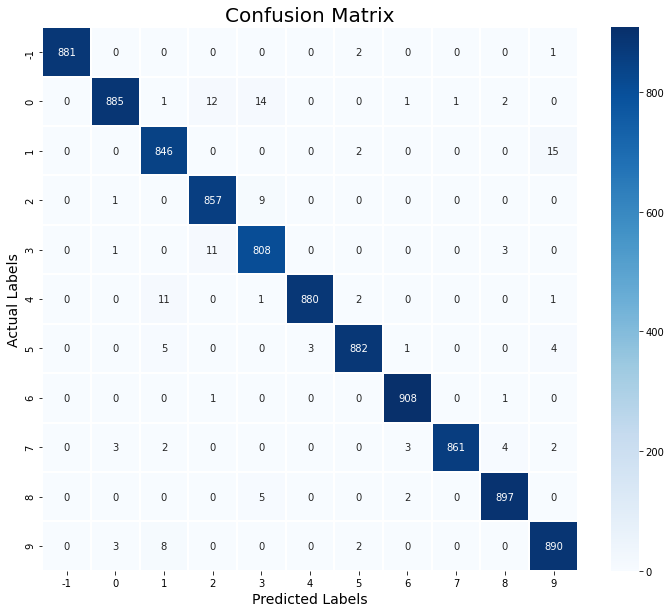

In [30]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in label_encoder.classes_] , columns = [i for i in label_encoder.classes_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()


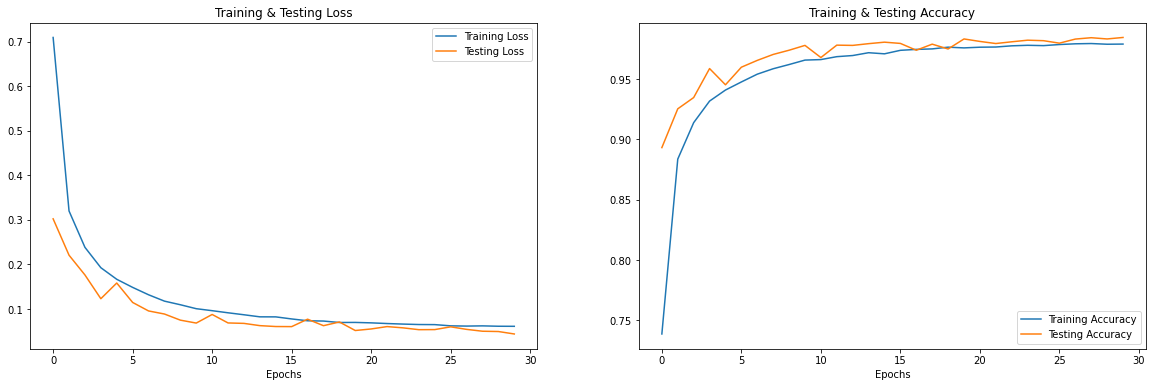

In [31]:
epochs = [i for i in range(30)]
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20,6)

ax[0].plot(epochs , train_losses, label = 'Training Loss')
ax[0].plot(epochs , valid_losses , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_accurases , label = 'Training Accuracy')
ax[1].plot(epochs , valid_accurases , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()


### Save Model

In [51]:
checkpoint = {'model': Conv1dBlock(),
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')
